# Weighted ECM clustering vs Traditional ECM clustering
## With Seeds dataset


In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
from evclust.utils import plotting, display_results_fuzzy_partition, display_results_evidential, ev_plot_2D
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from evclust.datasets import load_seeds

from evclust.ecm import ecm
from evclust.wecm_new_barycenter import wecm
from evclust.fcm.fcm_keller2000 import fcm as fcm_keller2000
from evclust.fcm.fcm_wang2004 import fcm as fcm_wang2004
from evclust.fcm.fcm_frigui2004 import scad1
from evclust.fcm.fcm_frigui2004 import scad2
from evclust.fcm.ifwfcm_xing2014 import fcm as ifwfcm_xing2014
from evclust.fcm.ifwfcm_kd_xing2014 import fcm as ifwfcm_kd_xing2014


      A     B    D    E    F    G
0  15.0  15.0  6.0  3.0  2.0  5.0
1  15.0  15.0  6.0  3.0  1.0  5.0
2  14.0  14.0  5.0  3.0  3.0  5.0
3  14.0  14.0  5.0  3.0  2.0  5.0
4  16.0  15.0  6.0  4.0  1.0  5.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


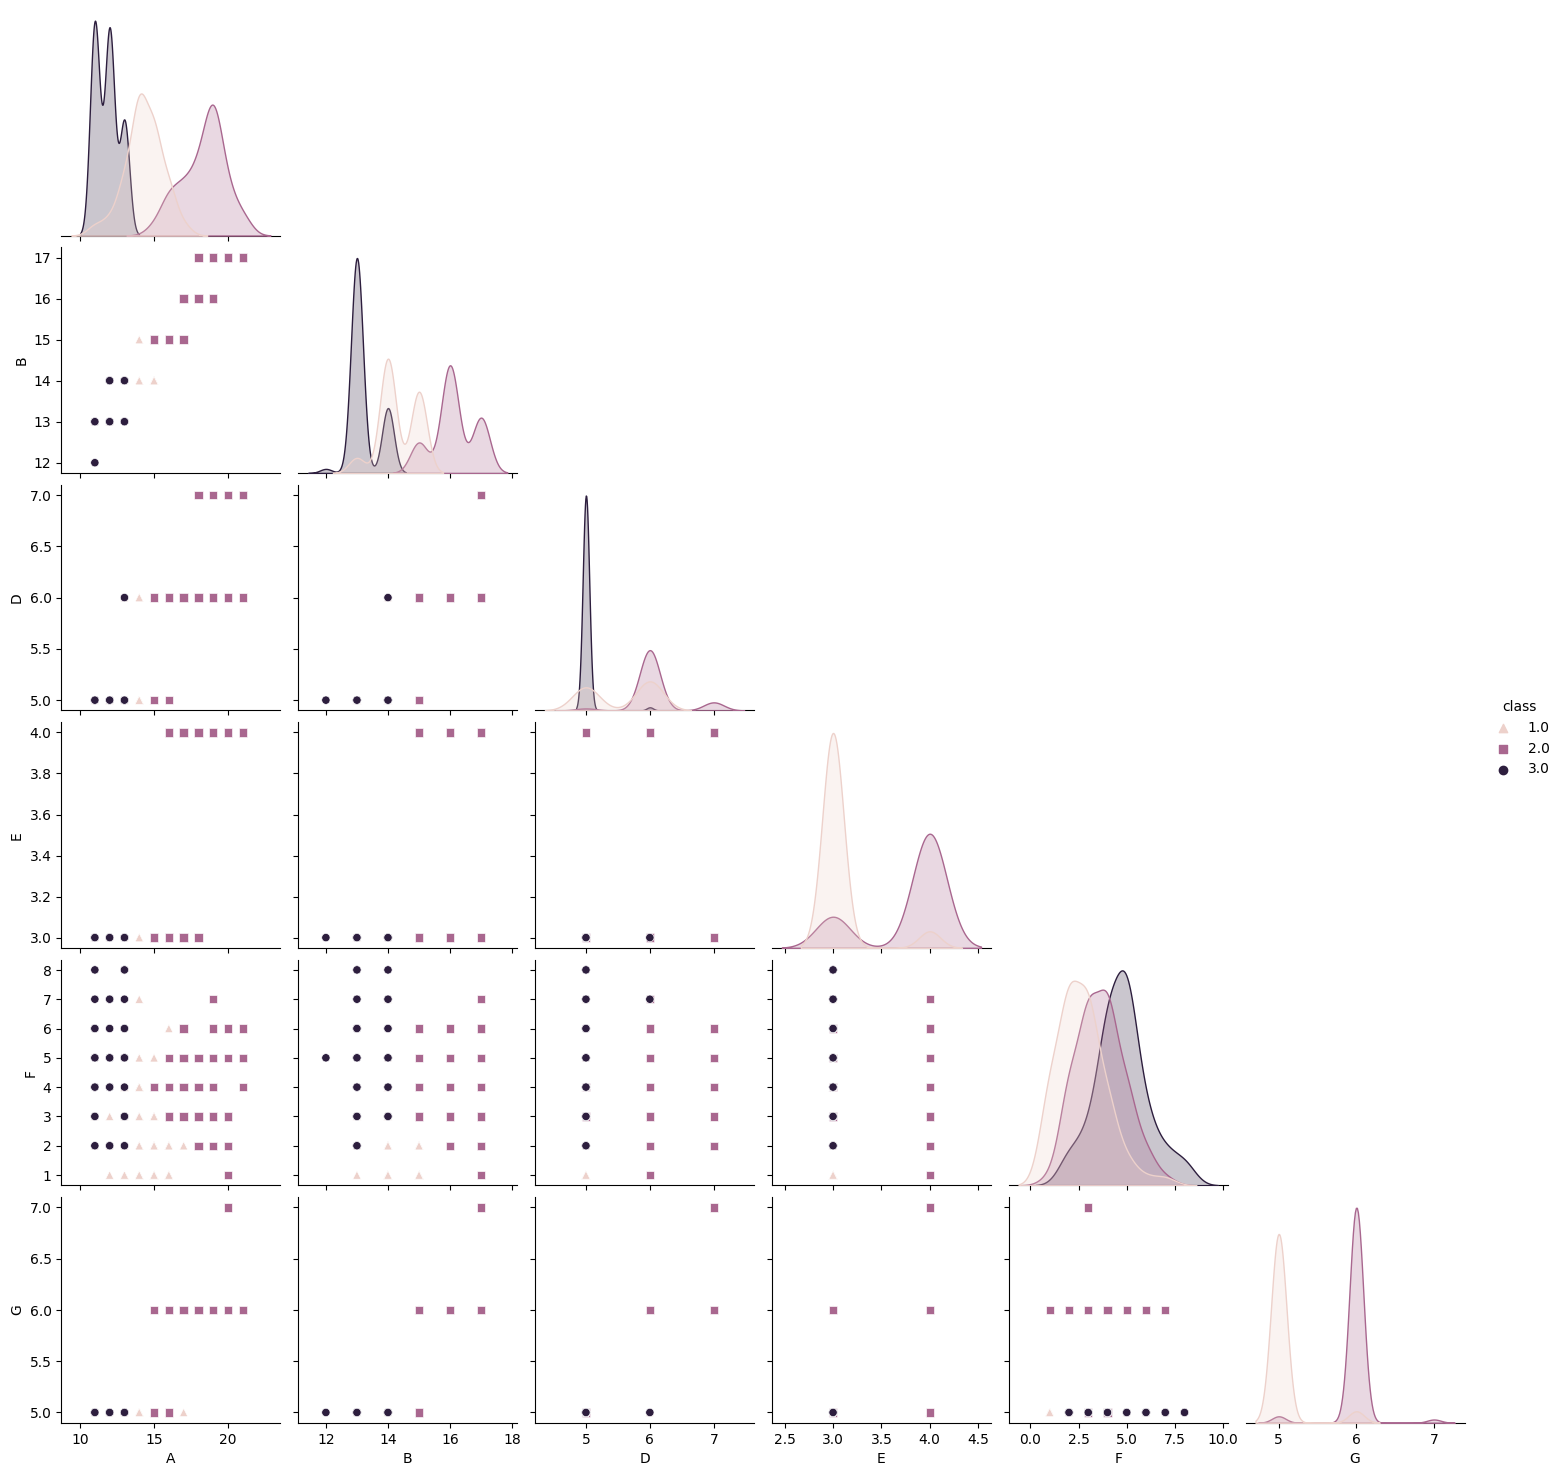

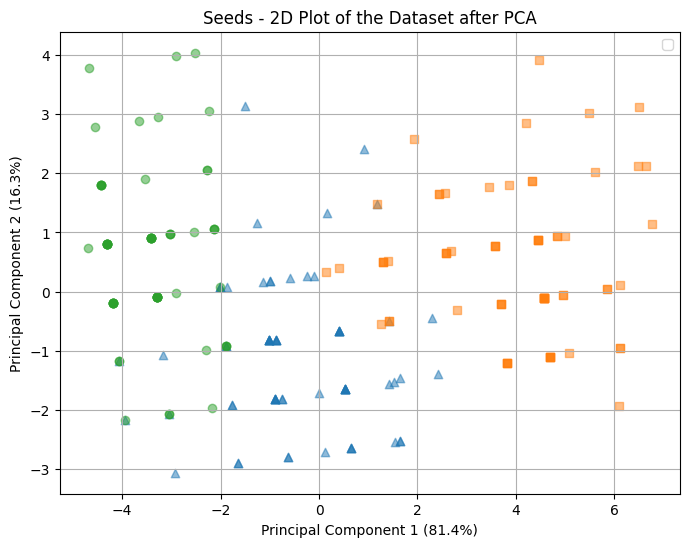

In [2]:
# fetch dataset
df = load_seeds()
df = df.drop(columns=['C'])  # all value equal 1
# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]
c = 3

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Seeds", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [23]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
ecm_models = np.array([])
for i in range(10):
    model = ecm(x=X, c=c, beta=2, alpha=1, delta=delta)
    ecm_models = np.append(ecm_models, model)

ecm_models = sorted(ecm_models, key=lambda x: x['crit'])

J values: [10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546, 10.650994305997546]
ARI values: [0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245]
NS values: [1.1261037136404282, 0.9897348678771584, 0.9350010923212825, 1.1261037136404282, 1.0904822246664856, 0.9350010923212825, 1.1445715692298903, 0.9897348678771584, 0.9897348678771584, 0.9350010923212825]
NMI values: [0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186]


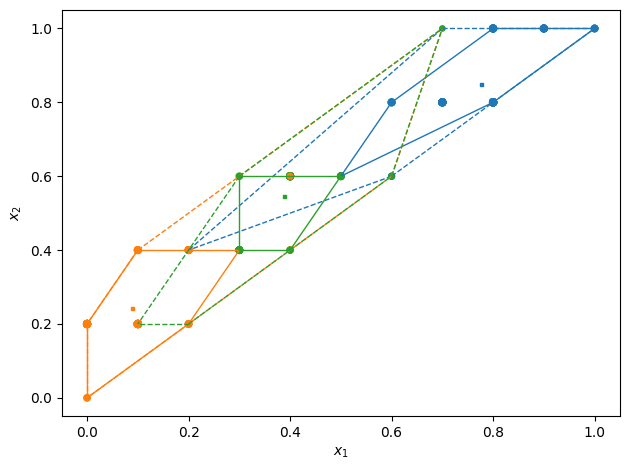

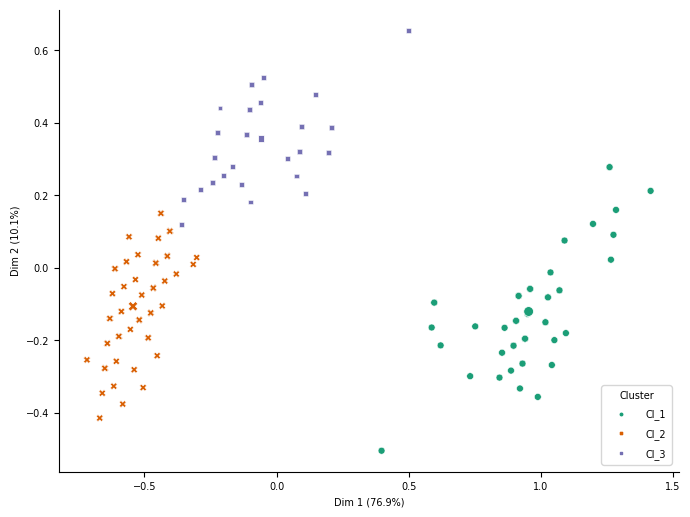

In [24]:
display_results_evidential(X, ecm_models, numeric_labels)

## Weighted ECM (WECM)

In [19]:
%%capture
wecm_models = np.array([])
d = X.shape[1]
delta = np.sqrt(20)
for i in range(10):
    model = wecm(x=X, c=c, beta=2, alpha=1, delta=delta)
    wecm_models = np.append(wecm_models, model)

wecm_models = sorted(wecm_models, key=lambda model: model['crit'])

J values: [2.540146584523179e-27, 2.540146584523179e-27, 3.625076848234887e-27, 3.625076848234887e-27, 5.076827432874495e-27, 5.076827432874495e-27, 5.076827432874495e-27, 5.076827432874495e-27, 6.163976367882203e-27, 6.163976367882203e-27]
ARI values: [0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005, 0.4354679248089005]
NS values: [0.7640137086856409, 0.7640137086856409, 0.9143847481087367, 0.9143847481087367, 0.9993953160316696, 0.9993953160316696, 0.9993953160316696, 0.9993953160316696, 0.7640137086856426, 0.7640137086856426]
NMI values: [0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691, 0.5297886979701691]


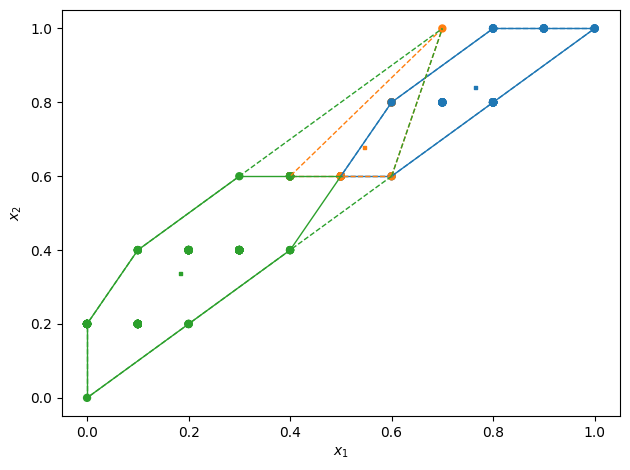

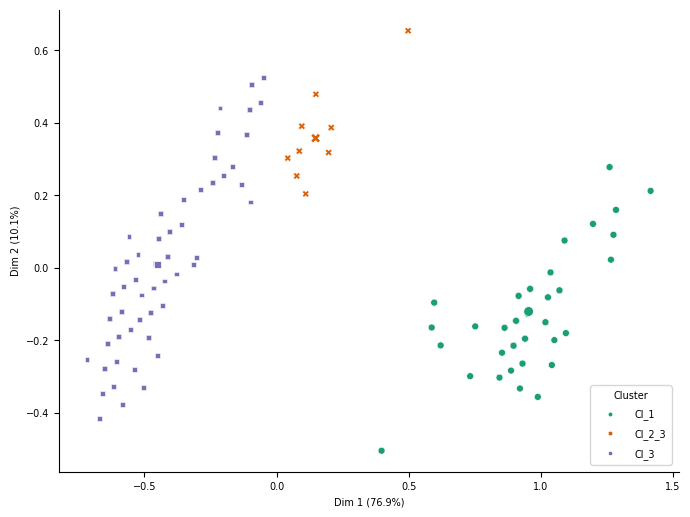

In [20]:
display_results_evidential(X, wecm_models, numeric_labels)

# Weighted FCM - Keller et al. 2000

In [6]:
%%capture
keller_models = np.array([])
# w0 = np.ones((c, X.shape[1])) / X.shape[1]
for i in range(10):
    model = fcm_keller2000(X, c=c, verbose=True)
    keller_models = np.append(keller_models, model)
keller_models = sorted(keller_models, key=lambda model: model['obj_func'])

J values: [8.050485729493473e-51, 6.405120341809163e-44, 7.465016414472641e-44, 5.192883595747326e-25, 3.3341373484182174e-20, 5.542943268641639e-20, 3.6172459225457294e-19, 9.618589287611435e-19, 1.9810752999631037e-15, 3.1564097082747018e-12]
ARI values: [0.4354679248089005, 0.31286729955204867, 0.31286729955204867, 0.31286729955204867, 0.5020571148398068, 0.31286729955204867, 0.5020571148398068, 0.5020571148398068, 0.4773038252456477, 0.5020571148398068]
NMI values: [0.5297886979701691, 0.39991402258714354, 0.39991402258714354, 0.39991402258714354, 0.596539492396706, 0.39991402258714354, 0.5965394923967061, 0.596539492396706, 0.5184774404320708, 0.596539492396706]


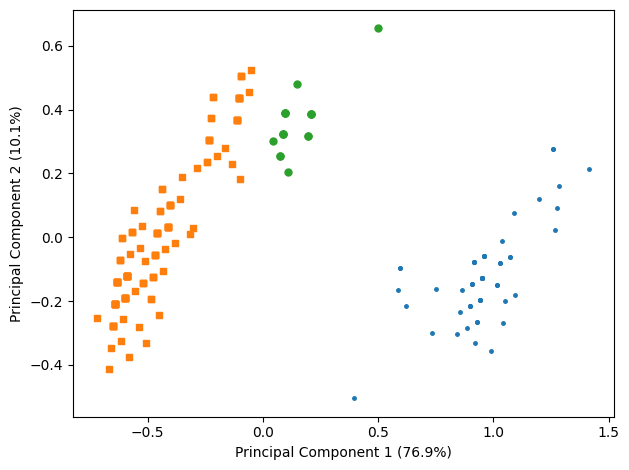

In [7]:
display_results_fuzzy_partition(X, keller_models, numeric_labels)

# Weighted FCM Wang 2004

In [8]:
%%capture
wang_models = np.array([])
for i in range(2):
    model = fcm_wang2004(X, c, w_beta=1.3, verbose=True)
    wang_models = np.append(wang_models, model)
wang_models = sorted(wang_models, key=lambda model: model['obj_func'])

J values: [0.4942811945146002, 0.49428119451460023]
ARI values: [0.4654336067506884, 0.4654336067506884]
NMI values: [0.4970895925681511, 0.4970895925681511]


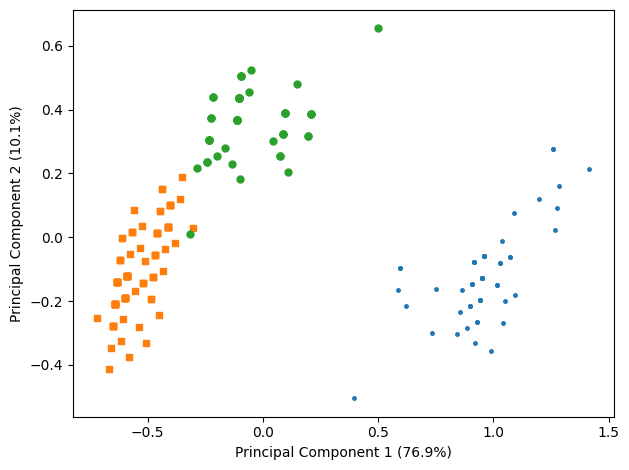

In [9]:
display_results_fuzzy_partition(X, wang_models, numeric_labels)

# SCAD1

In [41]:
%%capture
scad1_models = np.array([])
for i in range(10):
    model = scad1(X, c, verbose=True, K=4)
    scad1_models = np.append(scad1_models, model)
scad1_models = sorted(scad1_models, key=lambda model: model['obj_func'])


J values: [12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546575, 12.055770584546579, 12.055770584546579]
ARI values: [0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445, 0.4749156631589445]
NMI values: [0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571, 0.5179004971075571]


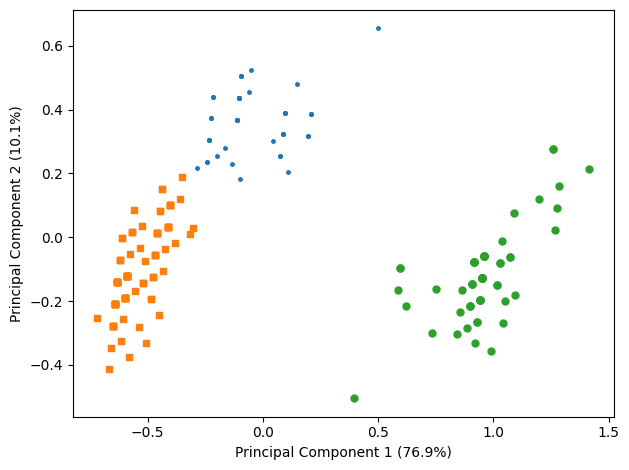

In [42]:
display_results_fuzzy_partition(X, scad1_models, numeric_labels)

# SCAD2

In [43]:
%%capture
scad2_models = np.array([])
for i in range(10):
    model = scad2(X, c, verbose=True)
    scad2_models = np.append(scad2_models, model)
scad2_models = sorted(scad2_models, key=lambda model: model['obj_func'])


J values: [2.210231123255975e-11, 2.210231123255975e-11, 2.210231123255978e-11, 2.210231123255978e-11, 2.210231123255978e-11, 2.210231123255978e-11, 2.2102311232560077e-11, 2.2102311232560077e-11, 2.2102311232560077e-11, 2.2102311232560077e-11]
ARI values: [0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804, 0.46999577428862804]
NMI values: [0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502, 0.5150911985908502]


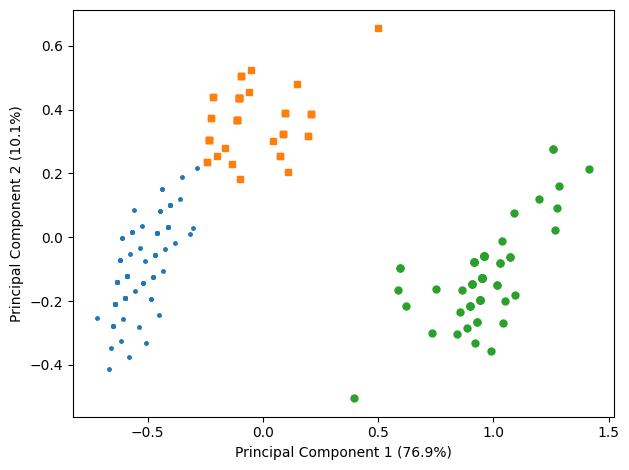

In [44]:
display_results_fuzzy_partition(X, scad2_models, numeric_labels)

# IFWFCM - Xing et al. 2014

In [14]:
%%capture
ifwfcm_models = np.array([])
for i in range(10):
    model = ifwfcm_xing2014(X, c, verbose=True)
    ifwfcm_models = np.append(ifwfcm_models, model)
ifwfcm_models = sorted(ifwfcm_models, key=lambda model: model['obj_func'])

J values: [0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.3154221113780944, 0.31542211137809445, 0.3154221113780945]
ARI values: [0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074, 0.6069224007002074]
NMI values: [0.6380292659281246, 0.6380292659281248, 0.6380292659281246, 0.6380292659281245, 0.6380292659281248, 0.6380292659281245, 0.6380292659281248, 0.6380292659281246, 0.6380292659281246, 0.6380292659281245]


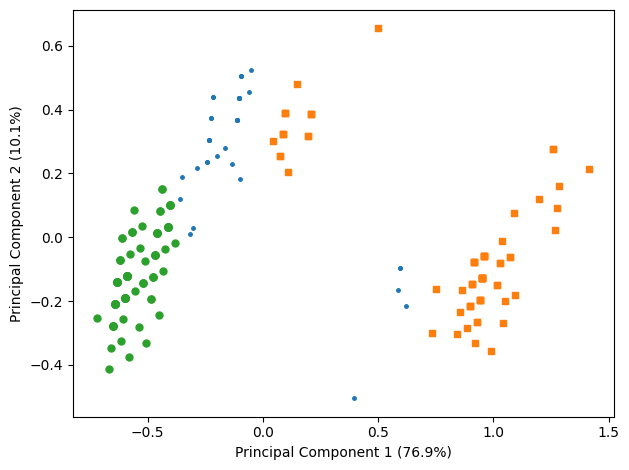

In [15]:
display_results_fuzzy_partition(X, ifwfcm_models, numeric_labels)

# IFWFCM_KD Xing 2014

In [45]:
%%capture
ifwfcm_kd_models = np.array([])
for i in range(10):
    model = ifwfcm_kd_xing2014(X, c, verbose=True, epsilon=1e-6)
    ifwfcm_kd_models = np.append(ifwfcm_kd_models, model)
ifwfcm_kd_models = sorted(ifwfcm_kd_models, key=lambda model: model['obj_func'])

J values: [0.581336383726861, 0.581336383726861, 0.581336383726861, 0.5813363837268611, 0.5813363837268611, 0.5813363837268611, 0.5813363837268611, 0.5813363837268611, 0.5813363837268612, 0.5813363837268612]
ARI values: [0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897, 0.7144229890829897]
NMI values: [0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821, 0.7023646838853821]


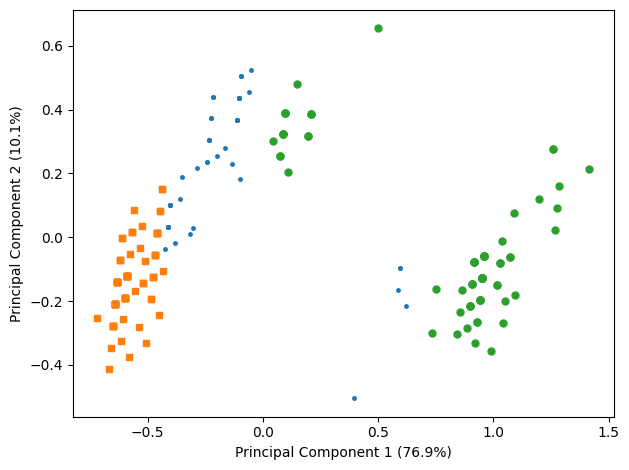

In [46]:
display_results_fuzzy_partition(X, ifwfcm_kd_models, numeric_labels)